In [ ]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
# from sklearn.linear_model import LogisticRegression

import networkx as nx
import math
import copy

import scipy.io as sio
from scipy.sparse import diags
import pickle


def lr_full_grad(X, y, w, rho):
    
    _, M = X.shape
    
    prob = np.exp(- y * X.dot(w))
    alpha = prob / (1 + prob)
    
    r_grad = 2*rho*np.sum(w/((1+w*w)*(1+w*w)))
    
    grad = r_grad - np.mean(alpha*y*X, axis = 0).reshape(M, 1)
    
    return grad


def get_loss(X, y, w, rho):
    
    prob = np.exp(- y * X.dot(w))
    J = np.mean(np.log(1 + prob))
    r = rho*np.sum(w*w/(1+w*w))
        
    return J + r


def get_lr_sol(X, y, step_size, maxite, rho):
    
    loss_record = np.zeros(maxite)
    
    _, M = X.shape
    w = np.zeros((M, 1))
    alpha = step_size
    
    for ite in range(maxite):
        
        if (ite + 1)%20 == 0:
            print ('iteration:', ite)
                
        grad = lr_full_grad(X, y, w, rho)
        w = w - alpha * grad
        
        loss_record[ite] = get_loss(X, y, w, rho)
        
    return w, loss_record


def lr_full_grad_dist(X, y, W, rho):
    
    total_sample_size, M = X.shape
    N = W.shape[0]
    S = total_sample_size//N    
    
    G = np.zeros((N, M))
    
    for i in range(N):
        
        wi = W[i,:].reshape(M, 1)        
        Xi = X[i*S:(i+1)*S, :]
        yi = y[i*S:(i+1)*S].reshape(S, 1)
        
        prob = np.exp(- yi * Xi.dot(wi))
        beta = prob / (1 + prob)

        r_grad = 2*rho*np.sum(wi/((1+wi*wi)*(1+wi*wi)))
        grad = r_grad - np.mean(beta*yi*Xi, axis = 0).reshape(M, 1)
        G[i,:] = grad.T
    
    return G


def lr_sto_grad_dist(X, y, W, rho):  
    
    total_sample_size, M = X.shape
    N = W.shape[0]
    S = total_sample_size//N    
    
    G = np.zeros((N, M))
    n = np.random.randint(1,1000)
    for i in range(N):
        
        wi = W[i,:].reshape(M, 1)        
        Xi = X[[i*S + n], :]
        yi = y[i*S + n]
        
        prob = np.exp(- yi * Xi.dot(wi))
        beta = prob / (1 + prob)

        r_grad = 2*rho*np.sum(wi/((1+wi*wi)*(1+wi*wi)))
        grad = r_grad - (beta*yi*Xi).reshape(M, 1)
        G[i,:] = grad.T
    
    return G


def lr_part_sto_grad_dist(X,y,W,rho): 
    
    total_sample_size, M = X.shape
    N = W.shape[0]
    S = total_sample_size//N    
    n_1 = 20
    G = np.zeros((N, M))
    for i in range(N):

        a = np.random.choice(S,n_1,replace=False) + i*S
        wi = W[i,:].reshape(M, 1) 
        Xi = X[a, :]
        yi = y[a].reshape(n_1,1)
        
        prob = np.exp(- yi * Xi.dot(wi))
        beta = prob / (1 + prob)

        r_grad = 2*rho*np.sum(wi/((1+wi*wi)*(1+wi*wi)))
        grad = r_grad - np.mean((beta*yi*Xi),axis = 0).reshape(M, 1)
        G[i,:] = grad.T
    
    return G

In [ ]:
def lr_generate_base_data(base_data_size,n,M,W0,N): 
    S = base_data_size//N
    X0 = np.zeros((base_data_size,M))
    y0 = np.zeros((base_data_size,1))
    for i in range(N):
        meani = np.array([(i+1)/2 for k in range(M)])
        #meani = np.array([0 for k in range(M)])
        cov = 3*np.eye(M)
        wi = W0[i,:].reshape(M, 1)
        Xi = np.random.multivariate_normal(meani,cov,S)
        #Xi = np.random.randn(S, M)
        yi = np.random.uniform(0.3+(i)/(2*N)-1/(8*N),0.3+(i+1)/(2*N)+1/(8*N),size=(S,1)) < 1 / (1 + np.exp(-Xi.dot(wi)))
        #yi = np.random.uniform(0,1,size=(S,1)) < 1 / (1 + np.exp(-Xi.dot(wi)))  
        yi = yi.astype(int)
        
        X0[i*S:(i+1)*S, :] = Xi
        y0[i*S:(i+1)*S] = yi
        
    return X0,y0


def lr_generate_noniid_data(total_sample_size,X0,y0,n,p0,alpha,N):
    M = X0.shape[1]
    base_data_size = X0.shape[0]
    S = total_sample_size//n
    S1 = base_data_size//N
    X = np.zeros((total_sample_size,M))
    y = np.zeros((total_sample_size,1))
    q = np.random.dirichlet(alpha*p0,n) 
    for i in range(n):
        class_labels = np.random.choice(N,size = S,p=q[i])
        sample_labels = np.random.choice(S1,size = S)
        Xi = np.zeros((S,M))
        yi = np.zeros((S,1))
        for k in range(S):
            c = class_labels[k]
            s = sample_labels[k]
            Xi[k] = X0[c*S1+s]
            yi[k] = y0[c*S1+s]
        X[i*S:(i+1)*S,:] = Xi
        y[i*S:(i+1)*S] = yi
    y = 2*y-1
    return X,y


np.random.seed(2022)
n, M = 30, 5 # n is the network size, M is the local data dimension
total_sample_size = n * 1000 # 8000 is the local data size at each node
base_data_size = total_sample_size * 10
rho = 0.001
N = 20

W0 = np.zeros((N, M)) 
for k in range(N):
    w_0k = np.random.normal(k-N/2,N, M)
    #w_0k = np.random.randn(1,M)
    w_0k = w_0k#/np.linalg.norm(w_0k)
    W0[k, :] = w_0k # non-iid scenario
# print(W0)
X0,y0 = lr_generate_base_data(base_data_size,n,M,W0,N)



In [3]:
def normalized_asynchronous_SGD(X,y,noise,gamma,theta,T,epochs,tau_mean0):
    M = X.shape[1]
    G = np.zeros((n,M))
    tau_mean = tau_mean0
    W = np.zeros((T+1,M))
    grad_norm = np.zeros((T+1,1))
    grad_norm_mean = np.zeros((T+1,1))
    for e in range(epochs):
        w0 = np.zeros((1,M))
        m = np.zeros(M)
        g = lr_full_grad(X,y,w0.T,rho)
        grad_norm[0] = np.linalg.norm(g,2)
        tau = np.zeros((n,3))
        for i in range(n):
            tau[i][2] = np.max([1,tau_mean[i] + 0.1 * np.random.randn()])
        tau[:,0] = -1
        for t in range(T):
            WW = np.zeros((n,M))
            for i in range(n):
                if t >= tau[i][2]:
                    tau[i][0] = tau[i][1]
                    tau[i][1] = tau[i][2]
                    a = tau[i][2]
                    b = a.astype(int)+1
                    c = a + max([0,tau_mean[i] + 0.1*np.random.randn()])
                    if c<b:
                        tau[i][2] = b
                    else:
                        tau[i][2] = c
                tau1 = tau[i][0].astype(int) + 1
                WW[i] = W[tau1]
                
            G = lr_part_sto_grad_dist(X,y,WW,rho) + noise * np.random.randn(n, M)
            g_mean = np.mean(G,axis = 0)
            m = theta * m + (1-theta) * g_mean
            W[t+1] = W[t] - gamma * m/np.linalg.norm(m)

            w = W[t+1].reshape(1,M)
            g = lr_full_grad(X, y, w.T, rho)
            grad_norm[t+1] = np.linalg.norm(g, 2)

        grad_norm_mean += grad_norm
    grad_norm_mean = grad_norm_mean / epochs
    return grad_norm_mean 

In [4]:
def asynchronous_SGD(X,y,noise,gamma,T,epochs,tau_mean0):
    M = X.shape[1]
    G = np.zeros((n,M))
    tau_mean = tau_mean0
    W = np.zeros((T+1,M))
    grad_norm = np.zeros((T+1,1))
    grad_norm_mean = np.zeros((T+1,1))
    for e in range(epochs):
        w0 = np.zeros((1,M))
        g = lr_full_grad(X,y,w0.T,rho)
        grad_norm[0] = np.linalg.norm(g,2)
        tau = np.zeros((n,3))
        for i in range(n):
            tau[i][2] = np.max([1.,tau_mean[i] + 0.1 * np.random.randn()])
        tau[:,0] = -1
        for t in range(T):
            WW = np.zeros((n,M))
            for i in range(n):
                if t >= tau[i][2]:
                    tau[i][0] = tau[i][1]
                    tau[i][1] = tau[i][2]
                    a = tau[i][2]
                    b = a.astype(int)+1
                    c = a + max([0,tau_mean[i] + 0.1*np.random.randn()])
                    if c<b:
                        tau[i][2] = b
                    else:
                        tau[i][2] = c
                tau1 = tau[i][0].astype(int)+1
                WW[i] = W[tau1]
                #print(tau1,t)    
                
            G = lr_part_sto_grad_dist(X,y,WW,rho) + noise * np.random.randn(n, M)
            g_mean = np.mean(G,axis = 0)
            W[t+1] = W[t] - gamma * g_mean

            w = W[t+1].reshape(1,M)
            g = lr_full_grad(X, y, w.T, rho)
            grad_norm[t+1] = np.linalg.norm(g, 2)

        grad_norm_mean += grad_norm
    grad_norm_mean = grad_norm_mean / epochs
    return grad_norm_mean

In [10]:
alpha1,alpha2,alpha3= 1000, 1, 0.001
L = 1
var = np.var(X0,axis=0)
sigma2 = max(var) + 0.1
p0 = np.ones(N)
X1,y1 = lr_generate_noniid_data(total_sample_size,X0,y0,n,p0,alpha1,N)
X2,y2 = lr_generate_noniid_data(total_sample_size,X0,y0,n,p0,alpha2,N)
X3,y3 = lr_generate_noniid_data(total_sample_size,X0,y0,n,p0,alpha3,N)


In [ ]:
T, epochs = 500, 20
noise = 0.01
theta = 0.2
gamma = 0.001
gamma1 = 0.001
w0 = np.zeros((1,M))
tau_mean0 = np.zeros(n)
tau_mean0 = np.random.gamma(4,1/2,n)
normalized_asyn_sgd1 = normalized_asynchronous_SGD(X1,y1,noise,gamma1,theta,T,epochs,tau_mean0)
normalized_asyn_sgd2 = normalized_asynchronous_SGD(X2,y2,noise,gamma1,theta,T,epochs,tau_mean0)
normalized_asyn_sgd3 = normalized_asynchronous_SGD(X3,y3,noise,gamma1,theta,T,epochs,tau_mean0)
asyn_sgd1 = asynchronous_SGD(X1,y1,noise,gamma,T,epochs,tau_mean0)
asyn_sgd2 = asynchronous_SGD(X2,y2,noise,gamma,T,epochs,tau_mean0)
asyn_sgd3 = asynchronous_SGD(X3,y3,noise,gamma,T,epochs,tau_mean0)


x_arr = np.arange(0, normalized_asyn_sgd1.shape[0], 1)

plt.semilogy(x_arr, normalized_asyn_sgd1[x_arr], linewidth=1.0, color='red',linestyle='dashed')
plt.semilogy(x_arr, normalized_asyn_sgd2[x_arr], linewidth=1.0, color='green',linestyle='dashed')
plt.semilogy(x_arr, normalized_asyn_sgd3[x_arr], linewidth=1.0, color='blue',linestyle='dashed')
plt.semilogy(x_arr, asyn_sgd1[x_arr], linewidth=1.0, color='red',linestyle='solid')
plt.semilogy(x_arr, asyn_sgd2[x_arr], linewidth=1.0, color='green',linestyle='solid')
plt.semilogy(x_arr, asyn_sgd3[x_arr], linewidth=1.0, color='blue',linestyle='solid')

plt.legend(['Normalized_Asyn_SGD_alpha=10', 'Normalized_Asyn_SGD_alpha=1','Normalized_Asyn_SGD_alpha=0.1','Asyn_SGD_alpha=10','Asyn_SGD_alpha=1','Asyn_SGD_alpha=0.1'], fontsize=10)
plt.xlabel('iteration', fontsize = 10)
plt.ylabel('gradient norm', fontsize = 10)
plt.title('N={},theta={},gamma={},noise={}'.format(n,theta,gamma,noise), fontsize = 10)

Text(0, 0.5, 'gradient norm')

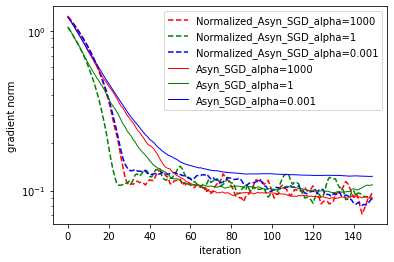

In [ ]:
x_arr = np.arange(0, normalized_asyn_sgd1[0:150].shape[0], 1)
plt.semilogy(x_arr, normalized_asyn_sgd1[x_arr], linewidth=1.5, color='red',linestyle='dashed')
plt.semilogy(x_arr, normalized_asyn_sgd2[x_arr], linewidth=1.5, color='green',linestyle='dashed')
plt.semilogy(x_arr, normalized_asyn_sgd3[x_arr], linewidth=1.5, color='blue',linestyle='dashed')
plt.semilogy(x_arr, asyn_sgd1[x_arr], linewidth=1.0, color='red',linestyle='solid')
plt.semilogy(x_arr, asyn_sgd2[x_arr], linewidth=1.0, color='green',linestyle='solid')
plt.semilogy(x_arr, asyn_sgd3[x_arr], linewidth=1.0, color='blue',linestyle='solid')

plt.legend(['Normalized_Asyn_SGD_alpha=1000', 'Normalized_Asyn_SGD_alpha=1','Normalized_Asyn_SGD_alpha=0.001','Asyn_SGD_alpha=1000','Asyn_SGD_alpha=1','Asyn_SGD_alpha=0.001'], fontsize=10)
plt.xlabel('iteration', fontsize = 10)
plt.ylabel('gradient norm', fontsize = 10)


Text(0, 0.5, 'gradient norm')

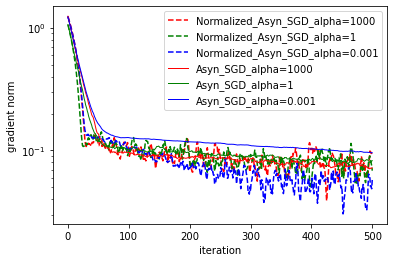

In [25]:
x_arr = np.arange(0, normalized_asyn_sgd1.shape[0], 1)
plt.semilogy(x_arr, normalized_asyn_sgd1[x_arr], linewidth=1.5, color='red',linestyle='dashed')
plt.semilogy(x_arr, normalized_asyn_sgd2[x_arr], linewidth=1.5, color='green',linestyle='dashed')
plt.semilogy(x_arr, normalized_asyn_sgd3[x_arr], linewidth=1.5, color='blue',linestyle='dashed')
plt.semilogy(x_arr, asyn_sgd1[x_arr], linewidth=1.0, color='red',linestyle='solid')
plt.semilogy(x_arr, asyn_sgd2[x_arr], linewidth=1.0, color='green',linestyle='solid')
plt.semilogy(x_arr, asyn_sgd3[x_arr], linewidth=1.0, color='blue',linestyle='solid')

plt.legend(['Normalized_Asyn_SGD_alpha=1000', 'Normalized_Asyn_SGD_alpha=1','Normalized_Asyn_SGD_alpha=0.001','Asyn_SGD_alpha=1000','Asyn_SGD_alpha=1','Asyn_SGD_alpha=0.001'], fontsize=10)
plt.xlabel('iteration', fontsize = 10)
plt.ylabel('gradient norm', fontsize = 10)


In [ ]:
a = np.concatenate((normalized_asyn_sgd1,normalized_asyn_sgd2,normalized_asyn_sgd3,asyn_sgd1,asyn_sgd2,asyn_sgd3),axis=1)
np.savetxt('Asyn_artificial.txt',a)